# NB04: NMDC Metagenomic Analysis of PHB Pathway Prevalence

**Purpose**: Test PHB pathway prevalence across NMDC environments using independent metagenomic data.

**Requires**: BERDL JupyterHub (Spark session)

**Inputs**:
- `data/phb_species_summary.tsv` from NB01
- `data/phb_by_taxonomy.tsv` from NB02

**Outputs**:
- `data/nmdc_phb_prevalence.tsv` — per-sample PHB inference scores
- `data/nmdc_study_summary.tsv` — study-level PHB summary
- `figures/nmdc_phb_by_environment.png` — PHB prevalence across NMDC environments
- `figures/nmdc_phb_vs_abiotic.png` — PHB signal vs abiotic variability

## Strategy

Two paths depending on data availability (explored in NB01):
- **Path A** (preferred): If per-sample functional annotations (KO counts) exist, directly count PHB pathway KOs
- **Path B** (fallback): Infer PHB capability from taxonomic composition × pangenome PHB status

In [1]:
spark = get_spark_session()

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

PROJECT_DIR = os.path.expanduser('~/BERIL-research-observatory/projects/phb_granule_ecology')
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
FIG_DIR = os.path.join(PROJECT_DIR, 'figures')

# Load NB01/NB02 results
species_phb = pd.read_csv(os.path.join(DATA_DIR, 'phb_species_summary.tsv'), sep='\t')
tax_phb = pd.read_csv(os.path.join(DATA_DIR, 'phb_by_taxonomy.tsv'), sep='\t')
print(f'Loaded {len(species_phb):,} PHB+ species, {len(tax_phb):,} total species')

Loaded 19,496 PHB+ species, 27,690 total species


## Part 1: NMDC Study & Sample Overview

In [2]:
# Overview of NMDC studies
studies = spark.sql("""
    SELECT * FROM nmdc_arkin.study_table
""").toPandas()

print(f'Total NMDC studies: {len(studies)}')
print(f'\nColumns: {list(studies.columns)}')
studies.head(10)

Total NMDC studies: 48

Columns: ['study_id', 'name', 'description', 'ecosystem', 'ecosystem_category', 'ecosystem_type', 'ecosystem_subtype', 'specific_ecosystem', 'principal_investigator_has_raw_value', 'principal_investigator_profile_image_url', 'principal_investigator_orcid', 'principal_investigator_type', 'type', 'funding_sources', 'has_credit_associations', 'gold_study_identifiers', 'title', 'study_category', 'associated_dois', 'protocol_link', 'principal_investigator_name', 'websites', 'part_of', 'principal_investigator_email', 'study_image', 'insdc_bioproject_identifiers', 'homepage_website', 'gnps_task_identifiers', 'jgi_portal_study_identifiers', 'notes', 'emsl_project_identifiers', 'alternative_names']


,study_id,name,description,ecosystem,ecosystem_category,ecosystem_type,ecosystem_subtype,specific_ecosystem,principal_investigator_has_raw_value,principal_investigator_profile_image_url,...,part_of,principal_investigator_email,study_image,insdc_bioproject_identifiers,homepage_website,gnps_task_identifiers,jgi_portal_study_identifiers,notes,emsl_project_identifiers,alternative_names
0,nmdc:sty-11-8fb6t785,Deep subsurface shale carbon reservoir microbi...,This project aims to improve the understanding...,Environmental,Terrestrial,Deep subsurface,Unclassified,Unclassified,Kelly Wrighton,https://portal.nersc.gov/project/m3408/profile...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,nmdc:sty-11-33fbta56,"Peatland microbial communities from Minnesota,...",This study is part of the Spruce and Peatland ...,Environmental,Aquatic,Freshwater,Wetlands,Unclassified,Christopher Schadt,https://portal.nersc.gov/project/m3408/profile...,...,"[""nmdc:sty-11-cytnjc39""]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,nmdc:sty-11-aygzgv51,Riverbed sediment microbial communities from t...,This research project aimed to understand how ...,Environmental,Aquatic,Freshwater,River,Sediment,James Stegen,https://portal.nersc.gov/project/m3408/profile...,...,"[""nmdc:sty-11-x4aawf73"", ""nmdc:sty-11-xcbexm97""]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,nmdc:sty-11-34xj1150,National Ecological Observatory Network: soil ...,This study contains the quality-controlled lab...,NaN,NaN,NaN,NaN,NaN,Kate Thibault,https://portal.nersc.gov/project/m3408/profile...,...,"[""nmdc:sty-11-nxrz9m96""]",kthibault@battelleecology.org,"[{""url"": ""https://portal.nersc.gov/project/m34...","[""bioproject:PRJNA406974"", ""bioproject:PRJNA10...","[""https://www.neonscience.org/""]",NaN,NaN,NaN,NaN,NaN
4,nmdc:sty-11-076c9980,Lab enrichment of tropical soil microbial comm...,This study is part of the Microbes Persist: Sy...,Environmental,Terrestrial,Soil,Unclassified,Forest Soil,Jennifer Pett-Ridge,https://portal.nersc.gov/project/m3408/profile...,...,"[""nmdc:sty-11-msexsy29""]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,nmdc:sty-11-t91cwb40,Determining the genomic basis for interactions...,The goal of this work is to develop the knowle...,NaN,NaN,NaN,NaN,NaN,Michelle O'Malley,https://chemengr.ucsb.edu/sites/default/files/...,...,NaN,momalley@engineering.ucsb.edu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,nmdc:sty-11-5bgrvr62,Freshwater microbial communities from Lake Men...,The goal of this study is to examine long-term...,NaN,NaN,NaN,NaN,NaN,Katherine McMahon,https://portal.nersc.gov/project/m3408/profile...,...,NaN,tmcmahon@cae.wisc.edu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,nmdc:sty-11-5tgfr349,Freshwater microbial communities from rivers f...,Streams and rivers represent key functioning u...,Environmental,Aquatic,Freshwater,River,Unclassified,Kelly Wrighton,https://portal.nersc.gov/project/m3408/profile...,...,"[""nmdc:sty-11-x4aawf73"", ""nmdc:sty-11-xcbexm97""]",kwrighton@gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,nmdc:sty-11-dcqce727,Bulk soil microbial communities from the East ...,This research project aimed to understand how ...,Environmental,Terrestrial,Soil,Meadow,Bulk soil,Eoin Brodie,https://portal.nersc.gov/project/m3408/profile...,...,"[""nmdc:sty-11-2zhqs261""]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,nmdc:sty-11-1t150432,Populus root and rhizosphere microbial communi...,This study is part of the Plant-Microbe Interf...,Host-associated,Plants,Unclassified,Unclassified,Unclassified,Mitchel J. Doktycz,https://portal.nersc.gov/project/m3408/profile...,...,"[""nmdc:sty-11-f1he1955""]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Check available abiotic features — these provide environmental context
abiotic = spark.sql("""
    SELECT * FROM nmdc_arkin.abiotic_features LIMIT 5
""").toPandas()

print(f'Abiotic feature columns ({len(abiotic.columns)}):') 
for col in abiotic.columns:
    print(f'  {col}')
abiotic

Abiotic feature columns (22):
  sample_id
  annotations_ammonium_has_numeric_value
  annotations_ammonium_nitrogen_has_numeric_value
  annotations_calcium_has_numeric_value
  annotations_carb_nitro_ratio_has_numeric_value
  annotations_chlorophyll_has_numeric_value
  annotations_conduc_has_numeric_value
  annotations_depth_has_maximum_numeric_value
  annotations_depth_has_minimum_numeric_value
  annotations_depth_has_numeric_value
  annotations_diss_org_carb_has_numeric_value
  annotations_diss_oxygen_has_numeric_value
  annotations_magnesium_has_numeric_value
  annotations_manganese_has_numeric_value
  annotations_ph
  annotations_potassium_has_numeric_value
  annotations_samp_size_has_numeric_value
  annotations_soluble_react_phosp_has_numeric_value
  annotations_temp_has_numeric_value
  annotations_tot_nitro_content_has_numeric_value
  annotations_tot_org_carb_has_numeric_value
  annotations_tot_phosp_has_numeric_value


,sample_id,annotations_ammonium_has_numeric_value,annotations_ammonium_nitrogen_has_numeric_value,annotations_calcium_has_numeric_value,annotations_carb_nitro_ratio_has_numeric_value,annotations_chlorophyll_has_numeric_value,annotations_conduc_has_numeric_value,annotations_depth_has_maximum_numeric_value,annotations_depth_has_minimum_numeric_value,annotations_depth_has_numeric_value,...,annotations_magnesium_has_numeric_value,annotations_manganese_has_numeric_value,annotations_ph,annotations_potassium_has_numeric_value,annotations_samp_size_has_numeric_value,annotations_soluble_react_phosp_has_numeric_value,annotations_temp_has_numeric_value,annotations_tot_nitro_content_has_numeric_value,annotations_tot_org_carb_has_numeric_value,annotations_tot_phosp_has_numeric_value
0,nmdc:bsm-11-042nd237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,nmdc:bsm-11-622k6044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,nmdc:bsm-11-65a4xw75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,nmdc:bsm-11-93mc8g67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,nmdc:bsm-11-cpekyy11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# How many samples have abiotic data?
abiotic_count = spark.sql("""
    SELECT COUNT(*) as n_samples FROM nmdc_arkin.abiotic_features
""").toPandas()
print(f'Samples with abiotic features: {abiotic_count["n_samples"].iloc[0]:,}')

# Check taxonomy features — this is our primary path for PHB inference
tax_feat_sample = spark.sql("""
    SELECT * FROM nmdc_arkin.taxonomy_features LIMIT 5
""").toPandas()

print(f'\nTaxonomy feature columns ({len(tax_feat_sample.columns)}):')
# Show first 20 columns and last 5
cols = list(tax_feat_sample.columns)
for c in cols[:20]:
    print(f'  {c}')
if len(cols) > 25:
    print(f'  ... ({len(cols) - 25} more columns) ...')
    for c in cols[-5:]:
        print(f'  {c}')

tax_feat_count = spark.sql("""
    SELECT COUNT(*) as n FROM nmdc_arkin.taxonomy_features
""").toPandas()
print(f'\nSamples with taxonomy features: {tax_feat_count["n"].iloc[0]:,}')

Samples with abiotic features: 13,847



Taxonomy feature columns (3493):
  7
  11
  33
  34
  35
  41
  43
  48
  52
  56
  69
  114
  119
  125
  128
  192
  193
  266
  280
  287
  ... (3468 more columns) ...
  1891675
  330734
  1173288
  59505
  sample_id



Samples with taxonomy features: 6,365


In [5]:
# Check for per-sample functional annotations (Path A)
# Look for tables with KO counts per sample
print('=== Checking for per-sample functional annotation tables ===')

# Check metatranscriptomics_gold — might have per-sample functional counts
try:
    mt_sample = spark.sql("SELECT * FROM nmdc_arkin.metatranscriptomics_gold LIMIT 3").toPandas()
    print(f'\nmetatranscriptomics_gold columns: {list(mt_sample.columns)}')
    print(mt_sample)
except Exception as e:
    print(f'metatranscriptomics_gold: {e}')

# Check trait_features — has functional group columns
try:
    trait_sample = spark.sql("SELECT * FROM nmdc_arkin.trait_features LIMIT 3").toPandas()
    func_cols = [c for c in trait_sample.columns if 'functional_group' in c.lower() or 'function' in c.lower()]
    print(f'\ntrait_features: {len(trait_sample.columns)} columns')
    print(f'Functional group columns: {len(func_cols)}')
    for c in func_cols[:15]:
        print(f'  {c}: {trait_sample[c].iloc[0]}')
except Exception as e:
    print(f'trait_features: {e}')

=== Checking for per-sample functional annotation tables ===



metatranscriptomics_gold columns: ['file_id', 'file_name', 'feature_id', 'abundance_clr', 'img_gene_oid', 'img_scaffold_oid', 'length', 'locus_tag', 'locus_type', 'mean', 'meanA', 'median', 'medianA', 'reads_cnt', 'reads_cntA', 'rel_abundance', 'scaffold_accession', 'stdev', 'stdevA', 'strand']
                 file_id                                 file_name  \
0  nmdc:dobj-11-b6c71y63  nmdc_wfmtex-11-5rrtjb63.1.rnaseq_gea.txt   
1  nmdc:dobj-11-b6c71y63  nmdc_wfmtex-11-5rrtjb63.1.rnaseq_gea.txt   
2  nmdc:dobj-11-b6c71y63  nmdc_wfmtex-11-5rrtjb63.1.rnaseq_gea.txt   

                                feature_id  abundance_clr  \
0  nmdc:wfmtan-11-pz7mb992.1_0285335_1_186      -3.740977   
1  nmdc:wfmtan-11-pz7mb992.1_0285773_1_357       3.798582   
2  nmdc:wfmtan-11-pz7mb992.1_0288632_1_120       0.190849   

                              img_gene_oid                   img_scaffold_oid  \
0  nmdc:wfmtan-11-pz7mb992.1_0285335_1_186  nmdc:wfmtan-11-pz7mb992.1_0285335   
1  nmdc:wfmtan-


trait_features: 92 columns
Functional group columns: 76
  functional_group:aerobic_chemoheterotrophy: 0.4797079854270886
  functional_group:fermentation: 0.11009247214834544
  functional_group:nitrate_denitrification: 0.9161186013131078
  functional_group:nitrate_respiration: 0.2010580388949314
  functional_group:nitrogen_fixation: 1.250205848780634
  functional_group:dark_thiosulfate_oxidation: 0.6972798928243794
  functional_group:nitrate_reduction: -0.2778353814531425
  functional_group:aromatic_compound_degradation: 0.02723817788494637
  functional_group:aromatic_hydrocarbon_degradation: -0.024688930073488644
  functional_group:arsenite_oxidation_energy_yielding: 0.8522265114880153
  functional_group:cellulolysis: -0.2767377242452695
  functional_group:dark_hydrogen_oxidation: 0.21427390146906794
  functional_group:denitrification: 0.49989840901136173
  functional_group:human_pathogens_all: -0.22398956118211072
  functional_group:human_pathogens_pneumonia: 0.07243113016942969


In [6]:
# Check if KEGG KO annotations exist per sample
# annotation_terms_unified has COG, EC, GO, KEGG, MetaCyc — but is it per-sample?
print('=== Checking annotation_terms_unified ===')
ann_sample = spark.sql("""
    SELECT * FROM nmdc_arkin.annotation_terms_unified 
    WHERE source = 'KEGG'
    LIMIT 5
""").toPandas()
print(f'Columns: {list(ann_sample.columns)}')
ann_sample

=== Checking annotation_terms_unified ===


Columns: ['source', 'term_id', 'name', 'description', 'namespace', 'is_obsolete']


,source,term_id,name,description,namespace,is_obsolete


In [7]:
# Check if PHB-related KOs exist in NMDC KEGG terms
phb_kos = ['K03821', 'K00023', 'K00626', 'K05973', 'K14205', 'K18080']
ko_str = "','".join(phb_kos)

phb_in_nmdc = spark.sql(f"""
    SELECT * FROM nmdc_arkin.kegg_ko_terms
    WHERE ko_id IN ('{ko_str}')
""").toPandas()

print('PHB KOs in NMDC KEGG reference:')
if len(phb_in_nmdc) > 0:
    print(phb_in_nmdc[['ko_id', 'name']].to_string(index=False))
else:
    # Inspect table schema if no results
    all_kegg = spark.sql("SELECT * FROM nmdc_arkin.kegg_ko_terms LIMIT 5").toPandas()
    print(f'Columns: {list(all_kegg.columns)}')
    print(all_kegg)

PHB KOs in NMDC KEGG reference:
 ko_id name
K00023     
K00626     
K03821     
K05973     
K14205     


## Part 2: Taxonomy-Based PHB Inference (Path B)

The `taxonomy_features` table contains per-sample taxonomic profiles from metagenomic classification.
We infer PHB capability for each sample by weighting the taxonomic composition by the pangenome PHB status from NB01/NB02.

**PHB inference score** = Σ (relative_abundance_taxon_i × phaC_prevalence_in_clade_i)

In [8]:
# Load taxonomy dimension table to map numeric column IDs to taxon names
# taxonomy_features columns are numeric IDs (7, 11, 33, ...), not taxon names
tax_dim = spark.sql("""
    SELECT * FROM nmdc_arkin.taxonomy_dim
""").toPandas()

print(f'taxonomy_dim: {tax_dim.shape[0]} rows x {tax_dim.shape[1]} columns')
print(f'Columns: {list(tax_dim.columns)}')
tax_dim.head(10)

taxonomy_dim: 2594787 rows x 8 columns
Columns: ['taxid', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']


,taxid,kingdom,phylum,class,order,family,genus,species
0,2327552,Metazoa,Arthropoda,Insecta,Hymenoptera,Ichneumonidae,Diplazon,Diplazon sp. BBHYJ995-10
1,2327604,Metazoa,Arthropoda,Insecta,Diptera,Dixidae,Dixella,Dixella sp. JWDCH005-10
2,2327640,Metazoa,Arthropoda,Insecta,Hymenoptera,Tenthredinidae,Dolerus,Dolerus sp. BBHYL963-10
3,2327718,Metazoa,Arthropoda,Insecta,Diptera,Dolichopodidae,Unclassified,Dolichopodidae sp. BBDED019-10
4,2327755,Metazoa,Arthropoda,Insecta,Diptera,Dolichopodidae,Unclassified,Dolichopodidae sp. BBDIP137-09
5,2327915,Metazoa,Arthropoda,Insecta,Hymenoptera,Dryinidae,Unclassified,Dryinidae sp. BBHYI199-10
6,2327924,Metazoa,Arthropoda,Insecta,Hymenoptera,Dryinidae,Unclassified,Dryinidae sp. BBHYK068-10
7,2327948,Metazoa,Arthropoda,Insecta,Hymenoptera,Ichneumonidae,Dusona,Dusona sp. BBHYJ810-10
8,2328021,Metazoa,Arthropoda,Insecta,Diptera,Anthomyiidae,Egle,Egle sp. JWDCE183-10
9,2328102,Metazoa,Arthropoda,Insecta,Diptera,Empididae,Unclassified,Empididae sp. BBDED909-10


In [9]:
# Also check taxstring_lookup for alternative ID-to-name mapping
try:
    taxstring = spark.sql("""
        SELECT * FROM nmdc_arkin.taxstring_lookup LIMIT 20
    """).toPandas()
    print(f'taxstring_lookup columns: {list(taxstring.columns)}')
    print(f'Shape: {taxstring.shape}')
    taxstring.head(10)
except Exception as e:
    print(f'taxstring_lookup: {e}')

# Load taxonomy features
tax_features = spark.sql("""
    SELECT * FROM nmdc_arkin.taxonomy_features
""").toPandas()

print(f'\nTaxonomy features: {tax_features.shape[0]} samples x {tax_features.shape[1]} columns')
taxon_cols = [c for c in tax_features.columns if c != 'sample_id']
print(f'Taxon columns (first 20): {taxon_cols[:20]}')
print(f'Total taxon columns: {len(taxon_cols)}')

taxstring_lookup columns: ['taxid', 'taxstring', 'normalized_taxstring', 'rank_count']
Shape: (20, 4)



Taxonomy features: 6365 samples x 3493 columns
Taxon columns (first 20): ['7', '11', '33', '34', '35', '41', '43', '48', '52', '56', '69', '114', '119', '125', '128', '192', '193', '266', '280', '287']
Total taxon columns: 3492


In [10]:
# Build mapping from numeric taxon IDs (column names in taxonomy_features)
# to genus names that we can match to pangenome data
#
# Strategy: taxonomy_dim should have columns like taxon_id + taxon name/rank info
# We need to extract the genus-level name for each taxon ID

# Identify the ID column and name/rank columns in taxonomy_dim
print('taxonomy_dim columns and sample values:')
for col in tax_dim.columns:
    print(f'  {col}: {tax_dim[col].iloc[:3].tolist()}')

# Build ID → genus mapping
# The exact approach depends on taxonomy_dim schema (will adapt after seeing output above)
# Common patterns: taxon_id + lineage string, or taxon_id + rank + name

# Try to find genus from taxonomy_dim
id_col = tax_dim.columns[0]  # First column is likely the ID
print(f'\nUsing "{id_col}" as taxonomy ID column')

# Check which taxonomy_features column IDs exist in taxonomy_dim
taxon_id_set = set(str(x) for x in tax_dim[id_col])
matched_ids = [c for c in taxon_cols if c in taxon_id_set]
print(f'Taxon columns matched to taxonomy_dim: {len(matched_ids)}/{len(taxon_cols)}')

taxonomy_dim columns and sample values:
  taxid: [2327552, 2327604, 2327640]
  kingdom: ['Metazoa', 'Metazoa', 'Metazoa']
  phylum: ['Arthropoda', 'Arthropoda', 'Arthropoda']
  class: ['Insecta', 'Insecta', 'Insecta']
  order: ['Hymenoptera', 'Diptera', 'Hymenoptera']
  family: ['Ichneumonidae', 'Dixidae', 'Tenthredinidae']
  genus: ['Diplazon', 'Dixella', 'Dolerus']
  species: ['Diplazon sp. BBHYJ995-10', 'Dixella sp. JWDCH005-10', 'Dolerus sp. BBHYL963-10']

Using "taxid" as taxonomy ID column


Taxon columns matched to taxonomy_dim: 3451/3492


In [11]:
# Two-tier NCBI taxid → GTDB genus mapping
# Tier 1: Use gtdb_metadata to map NCBI taxids to GTDB genera (handles genus renames)
# Tier 2: Fallback to direct genus name matching via taxonomy_dim

# --- Tier 1: gtdb_metadata bridge (NCBI taxid → GTDB genus) ---
print('=== Tier 1: Mapping via gtdb_metadata ===')
ncbi_to_gtdb = spark.sql("""
    SELECT DISTINCT
        CAST(m.ncbi_species_taxid AS INT) as ncbi_taxid,
        REGEXP_EXTRACT(m.gtdb_taxonomy, 'g__([^;]+)', 1) AS gtdb_genus
    FROM kbase_ke_pangenome.gtdb_metadata m
    WHERE m.gtdb_taxonomy IS NOT NULL
      AND REGEXP_EXTRACT(m.gtdb_taxonomy, 'g__([^;]+)', 1) != ''
    UNION
    SELECT DISTINCT
        CAST(m.ncbi_taxid AS INT) as ncbi_taxid,
        REGEXP_EXTRACT(m.gtdb_taxonomy, 'g__([^;]+)', 1) AS gtdb_genus
    FROM kbase_ke_pangenome.gtdb_metadata m
    WHERE m.gtdb_taxonomy IS NOT NULL
      AND REGEXP_EXTRACT(m.gtdb_taxonomy, 'g__([^;]+)', 1) != ''
""").toPandas()

print(f'gtdb_metadata mappings: {len(ncbi_to_gtdb):,} (ncbi_taxid → gtdb_genus)')

# For taxids that map to multiple GTDB genera, take the most common
# (weighted by genome count)
ncbi_genus_counts = ncbi_to_gtdb.groupby('ncbi_taxid')['gtdb_genus'].agg(
    lambda x: x.value_counts().index[0]
).to_dict()

# Build Tier 1 mapping: NMDC taxid → GTDB genus
taxid_to_genus = {}
tier1_hits = 0
for col_id in taxon_cols:
    try:
        tid = int(col_id)
    except (ValueError, TypeError):
        continue
    if tid in ncbi_genus_counts:
        taxid_to_genus[col_id] = ncbi_genus_counts[tid]
        tier1_hits += 1

print(f'Tier 1 matches: {tier1_hits}/{len(taxon_cols)} taxon columns')

# --- Tier 2: Direct genus name matching via taxonomy_dim ---
print('\n=== Tier 2: Fallback via taxonomy_dim genus names ===')

# Build GTDB genus set (lowercase, stripped of g__ prefix)
gtdb_genus_set = set(
    tax_phb['gtdb_genus'].dropna().str.replace('g__', '', regex=False).str.strip().str.lower()
)

tier2_hits = 0
for col_id in taxon_cols:
    if col_id in taxid_to_genus:
        continue  # already matched in Tier 1
    # Look up in taxonomy_dim
    try:
        tid = int(col_id)
    except (ValueError, TypeError):
        continue
    matches = tax_dim[tax_dim['taxid'] == tid]
    if len(matches) > 0:
        genus = str(matches.iloc[0]['genus']).strip()
        if genus and genus.lower() != 'unclassified' and genus.lower() != 'nan':
            # Check if this genus exists in GTDB (case-insensitive)
            if genus.lower() in gtdb_genus_set:
                taxid_to_genus[col_id] = genus
                tier2_hits += 1

print(f'Tier 2 matches: {tier2_hits} additional taxon columns')
print(f'\nTotal mapped: {len(taxid_to_genus)}/{len(taxon_cols)} taxon columns')

# Show sample mappings
if taxid_to_genus:
    sample_items = list(taxid_to_genus.items())[:10]
    print(f'\nSample mappings:')
    for tid, genus in sample_items:
        print(f'  taxid {tid} → {genus}')

=== Tier 1: Mapping via gtdb_metadata ===


gtdb_metadata mappings: 72,819 (ncbi_taxid → gtdb_genus)


Tier 1 matches: 2336/3492 taxon columns

=== Tier 2: Fallback via taxonomy_dim genus names ===


Tier 2 matches: 678 additional taxon columns

Total mapped: 3014/3492 taxon columns

Sample mappings:
  taxid 7 → Azorhizobium
  taxid 11 → Cellulomonas
  taxid 33 → Myxococcus
  taxid 34 → Myxococcus
  taxid 35 → Myxococcus
  taxid 41 → Stigmatella
  taxid 48 → Archangium
  taxid 56 → Sorangium
  taxid 69 → Lysobacter
  taxid 114 → Gemmata


In [12]:
# Build genus-level PHB prevalence from pangenome data
genus_phb = tax_phb.groupby('gtdb_genus').agg(
    n_species=('gtdb_species_clade_id', 'count'),
    n_phaC=('has_phaC', 'sum'),
    pct_phaC=('has_phaC', lambda x: x.mean()),  # proportion, not percentage
).reset_index()
genus_phb['genus_clean'] = genus_phb['gtdb_genus'].str.replace('g__', '', regex=False).str.strip()

# Match NMDC taxon IDs → genus → pangenome PHB prevalence
genus_phb_lookup = dict(zip(genus_phb['genus_clean'].str.lower(), genus_phb['pct_phaC']))

# Build matched list: (taxon_col_name, genus_name) for columns we can map
matched = []
unmatched_ids = []
for col_id in taxon_cols:
    genus = taxid_to_genus.get(col_id, None)
    if genus and genus.lower() in genus_phb_lookup:
        matched.append((col_id, genus.lower()))
    else:
        unmatched_ids.append(col_id)

print(f'Matched taxon IDs to pangenome genera: {len(matched)}/{len(taxon_cols)}')
print(f'Unmatched: {len(unmatched_ids)}')
if matched:
    print(f'\nFirst 10 matches:')
    for col_id, genus in matched[:10]:
        print(f'  ID {col_id} → {genus} (phaC: {genus_phb_lookup[genus]*100:.1f}%)')

# Compute per-sample PHB inference score
sample_scores = []
for _, row in tax_features.iterrows():
    sample_id = row['sample_id']
    phb_score = 0.0
    total_abundance = 0.0
    matched_abundance = 0.0
    
    for col_id, genus in matched:
        abundance = pd.to_numeric(row.get(col_id, 0), errors='coerce')
        if pd.notna(abundance) and abundance > 0:
            phb_score += abundance * genus_phb_lookup.get(genus, 0)
            matched_abundance += abundance
    
    for col in taxon_cols:
        val = pd.to_numeric(row.get(col, 0), errors='coerce')
        if pd.notna(val) and val > 0:
            total_abundance += val
    
    sample_scores.append({
        'sample_id': sample_id,
        'phb_score': phb_score,
        'matched_abundance': matched_abundance,
        'total_abundance': total_abundance,
        'pct_matched': matched_abundance / total_abundance * 100 if total_abundance > 0 else 0,
    })

sample_phb = pd.DataFrame(sample_scores)
print(f'\nComputed PHB scores for {len(sample_phb):,} samples')
print(f'\nPHB score distribution:')
print(sample_phb['phb_score'].describe())
print(f'\nTaxon matching coverage:')
print(f'  Median % abundance matched: {sample_phb["pct_matched"].median():.1f}%')

Matched taxon IDs to pangenome genera: 3014/3492
Unmatched: 478

First 10 matches:
  ID 7 → azorhizobium (phaC: 100.0%)
  ID 11 → cellulomonas (phaC: 0.0%)
  ID 33 → myxococcus (phaC: 100.0%)
  ID 34 → myxococcus (phaC: 100.0%)
  ID 35 → myxococcus (phaC: 100.0%)
  ID 41 → stigmatella (phaC: 0.0%)
  ID 48 → archangium (phaC: 100.0%)
  ID 56 → sorangium (phaC: 0.0%)
  ID 69 → lysobacter (phaC: 100.0%)
  ID 114 → gemmata (phaC: 0.0%)



Computed PHB scores for 6,365 samples

PHB score distribution:
count    6365.000000
mean      201.519290
std       196.887166
min         0.000000
25%        97.257176
50%       137.683017
75%       215.878588
max      3747.657645
Name: phb_score, dtype: float64

Taxon matching coverage:
  Median % abundance matched: 87.2%


## Part 3: Correlate PHB Signal with Abiotic Features

In [13]:
# Load abiotic features
abiotic_all = spark.sql("""
    SELECT * FROM nmdc_arkin.abiotic_features
""").toPandas()

print(f'Abiotic features: {abiotic_all.shape[0]} samples x {abiotic_all.shape[1]} columns')

# Merge with PHB scores
phb_abiotic = sample_phb.merge(abiotic_all, on='sample_id', how='inner')
print(f'Samples with both PHB scores and abiotic data: {len(phb_abiotic):,}')

Abiotic features: 13847 samples x 22 columns
Samples with both PHB scores and abiotic data: 6,365


In [14]:
# Identify key abiotic variables for feast/famine hypothesis
# Focus on: dissolved oxygen, pH, temperature, carbon-related measures
abiotic_cols = [c for c in abiotic_all.columns if c != 'sample_id']

# Cast numeric columns and check coverage
print('Abiotic variable coverage:')
abiotic_coverage = []
for col in abiotic_cols:
    vals = pd.to_numeric(phb_abiotic[col], errors='coerce')
    n_valid = vals.notna().sum()
    if n_valid > 0:
        abiotic_coverage.append({
            'column': col,
            'n_valid': n_valid,
            'pct_valid': n_valid / len(phb_abiotic) * 100,
            'mean': vals.mean(),
            'std': vals.std(),
        })

abiotic_cov_df = pd.DataFrame(abiotic_coverage).sort_values('n_valid', ascending=False)
print(abiotic_cov_df.to_string(index=False))

Abiotic variable coverage:
                                           column  n_valid  pct_valid      mean       std
           annotations_ammonium_has_numeric_value     6365      100.0  0.000426  0.013643
  annotations_ammonium_nitrogen_has_numeric_value     6365      100.0  0.015054  0.108828
            annotations_calcium_has_numeric_value     6365      100.0  0.000162  0.128308
   annotations_carb_nitro_ratio_has_numeric_value     6365      100.0  0.113621  3.206513
        annotations_chlorophyll_has_numeric_value     6365      100.0  0.007133  0.567889
             annotations_conduc_has_numeric_value     6365      100.0  2.687196 67.466914
      annotations_depth_has_maximum_numeric_value     6365      100.0  1.278542  3.677013
      annotations_depth_has_minimum_numeric_value     6365      100.0  0.014719  0.312492
              annotations_depth_has_numeric_value     6365      100.0  0.010283  0.430240
      annotations_diss_org_carb_has_numeric_value     6365      100.0 -0.

In [15]:
# Link samples to studies for within-study variability analysis
# Check if study_table has sample-to-study mapping
print('study_table columns:', list(studies.columns))

# Try to get sample-study links from embeddings or metadata
try:
    emb_meta = spark.sql("""
        SELECT * FROM nmdc_arkin.embedding_metadata LIMIT 5
    """).toPandas()
    print(f'\nembedding_metadata columns: {list(emb_meta.columns)}')
    emb_meta
except Exception as e:
    print(f'embedding_metadata: {e}')

study_table columns: ['study_id', 'name', 'description', 'ecosystem', 'ecosystem_category', 'ecosystem_type', 'ecosystem_subtype', 'specific_ecosystem', 'principal_investigator_has_raw_value', 'principal_investigator_profile_image_url', 'principal_investigator_orcid', 'principal_investigator_type', 'type', 'funding_sources', 'has_credit_associations', 'gold_study_identifiers', 'title', 'study_category', 'associated_dois', 'protocol_link', 'principal_investigator_name', 'websites', 'part_of', 'principal_investigator_email', 'study_image', 'insdc_bioproject_identifiers', 'homepage_website', 'gnps_task_identifiers', 'jgi_portal_study_identifiers', 'notes', 'emsl_project_identifiers', 'alternative_names']



embedding_metadata columns: ['modality', 'loaded_from_checkpoint', '__index_level_0__']


In [16]:
# Correlate PHB score with key abiotic variables
# Select columns with sufficient coverage
target_keywords = ['oxygen', 'ph', 'temp', 'carbon', 'nitro', 'ammonium', 'salinity']
key_abiotic = []
for _, row in abiotic_cov_df.iterrows():
    col = row['column']
    if row['n_valid'] >= 30:  # minimum for meaningful correlation
        key_abiotic.append(col)

print(f'Abiotic variables with >=30 valid values: {len(key_abiotic)}')

# Compute Spearman correlations with PHB score
correlations = []
for col in key_abiotic:
    vals = pd.to_numeric(phb_abiotic[col], errors='coerce')
    valid = vals.notna() & phb_abiotic['phb_score'].notna()
    if valid.sum() >= 30:
        rho, p = stats.spearmanr(phb_abiotic.loc[valid, 'phb_score'], vals[valid])
        correlations.append({
            'abiotic_variable': col,
            'n': valid.sum(),
            'spearman_rho': rho,
            'p_value': p,
        })

corr_df = pd.DataFrame(correlations).sort_values('p_value')
print('\nSpearman correlations: PHB score vs abiotic variables')
print(corr_df.to_string(index=False))

Abiotic variables with >=30 valid values: 21

Spearman correlations: PHB score vs abiotic variables
                                 abiotic_variable    n  spearman_rho      p_value
              annotations_depth_has_numeric_value 6365     -0.119463 1.140736e-21
               annotations_temp_has_numeric_value 6365      0.088147 1.857975e-12
      annotations_depth_has_maximum_numeric_value 6365      0.076200 1.150782e-09
      annotations_depth_has_minimum_numeric_value 6365     -0.055197 1.052258e-05
                                   annotations_ph 6365      0.049438 7.951921e-05
  annotations_ammonium_nitrogen_has_numeric_value 6365      0.043976 4.490543e-04
      annotations_diss_org_carb_has_numeric_value 6365      0.024208 5.344858e-02
  annotations_tot_nitro_content_has_numeric_value 6365      0.022050 7.857425e-02
            annotations_calcium_has_numeric_value 6365     -0.014937 2.334574e-01
   annotations_carb_nitro_ratio_has_numeric_value 6365     -0.013970 2.651102e-0

In [17]:
# Check trait_features for PHB-relevant functional groups
traits = spark.sql("""
    SELECT * FROM nmdc_arkin.trait_features
""").toPandas()

print(f'Trait features: {traits.shape[0]} samples x {traits.shape[1]} columns')

# Look for PHB-related traits
phb_trait_cols = [c for c in traits.columns 
                  if any(kw in c.lower() for kw in ['pha', 'phb', 'polyhydrox', 
                         'carbon_storage', 'granule', 'storage'])]
print(f'\nPHB-related trait columns: {phb_trait_cols}')

# Also check for general metabolic traits that might correlate
metab_trait_cols = [c for c in traits.columns 
                    if any(kw in c.lower() for kw in ['ferment', 'aerob', 'anaerob',
                           'respir', 'nitrogen', 'carbon', 'fatty_acid'])]
print(f'Metabolic trait columns: {metab_trait_cols[:15]}')

Trait features: 6365 samples x 92 columns

PHB-related trait columns: ['functional_group:aliphatic_non_methane_hydrocarbon_degradation']
Metabolic trait columns: ['functional_group:aerobic_chemoheterotrophy', 'functional_group:fermentation', 'functional_group:nitrate_respiration', 'functional_group:nitrogen_fixation', 'functional_group:aromatic_hydrocarbon_degradation', 'functional_group:nitrite_respiration', 'functional_group:aerobic_nitrite_oxidation', 'functional_group:aerobic_anoxygenic_phototrophy', 'functional_group:aliphatic_non_methane_hydrocarbon_degradation', 'functional_group:iron_respiration', 'functional_group:sulfite_respiration', 'functional_group:thiosulfate_respiration', 'functional_group:hydrocarbon_degradation', 'functional_group:fumarate_respiration', 'functional_group:manganese_respiration']


In [18]:
# If PHB-related traits exist, correlate with our PHB inference score
if phb_trait_cols:
    traits_phb = traits[['sample_id'] + phb_trait_cols].merge(
        sample_phb[['sample_id', 'phb_score']], on='sample_id', how='inner')
    
    for col in phb_trait_cols:
        vals = pd.to_numeric(traits_phb[col], errors='coerce')
        valid = vals.notna() & traits_phb['phb_score'].notna()
        if valid.sum() >= 10:
            rho, p = stats.spearmanr(traits_phb.loc[valid, 'phb_score'], vals[valid])
            print(f'{col}: rho={rho:.3f}, p={p:.2e}, n={valid.sum()}')
else:
    print('No PHB-specific trait columns found in trait_features.')
    print('Will rely on taxonomy-based inference only.')

functional_group:aliphatic_non_methane_hydrocarbon_degradation: rho=0.051, p=4.01e-05, n=6365


In [19]:
# Check metabolomics for 3-hydroxybutyrate / PHB monomers
try:
    metab_sample = spark.sql("""
        SELECT * FROM nmdc_arkin.metabolomics_gold LIMIT 5
    """).toPandas()
    print(f'metabolomics_gold columns: {list(metab_sample.columns)}')
    metab_sample
except Exception as e:
    print(f'metabolomics_gold error: {e}')

metabolomics_gold columns: ['file_id', 'file_name', 'feature_id', 'Apex Scan Number', 'Area', 'Associated Mass Features after Deconvolution', 'Calculated m/z', 'Confidence Score', 'Dispersity Index', 'Entropy Similarity', 'Intensity', 'Ion Formula', 'Ion Type', 'Is Largest Ion after Deconvolution', 'Isotopologue Similarity', 'Isotopologue Type', 'Library mzs in Query (fraction)', 'MS2 Spectrum', 'Mass Feature ID', 'Molecular Formula', 'Monoisotopic Mass Feature ID', 'Persistence', 'Polarity', 'Retention Time (min)', 'Sample Name', 'Spectra with Annotation (n)', 'Tailing Factor', 'chebi', 'database_name', 'final_scan', 'inchi', 'inchikey', 'kegg', 'm/z', 'm/z Error (ppm)', 'm/z Error Score', 'name', 'noise_score', 'noise_score_max', 'noise_score_min', 'normalized_dispersity_index', 'ref_ms_id', 'smiles', 'start_scan', 'Peak Area', 'Traditional Name', 'Spectral Similarity Score', 'Similarity Score', 'Retention Time Ref', 'Retention Index Score', 'Kegg Compound ID', 'Retention index Ref',

In [20]:
# Search metabolomics for 3-hydroxybutyrate or related compounds
# From NB01b: columns include "Compound Name", "Common Name", "Traditional Name", "name"
# Use backticks for columns with spaces
try:
    phb_metabolites = spark.sql("""
        SELECT DISTINCT `Compound Name`, `Common Name`, `Traditional Name`, name, kegg, smiles,
               `Sample Name`
        FROM nmdc_arkin.metabolomics_gold
        WHERE LOWER(`Compound Name`) LIKE '%hydroxybutyrat%'
           OR LOWER(`Compound Name`) LIKE '%phb%'
           OR LOWER(name) LIKE '%hydroxybutyrat%'
           OR LOWER(`Common Name`) LIKE '%hydroxybutyrat%'
        LIMIT 20
    """).toPandas()
    
    if len(phb_metabolites) > 0:
        print(f'Found PHB-related metabolites: {len(phb_metabolites)}')
        print(phb_metabolites)
    else:
        print('No PHB-related metabolites found by name.')
except Exception as e:
    print(f'Metabolomics query failed: {e}')

No PHB-related metabolites found by name.


## Part 4: Visualize PHB Signal Across NMDC Environments

In [21]:
# Classify NMDC samples by environment type
# The study_table and embedding_metadata may have env_* or ecosystem_* columns

# First check study_table for ecosystem columns
print('=== study_table ===')
study_cols = list(studies.columns)
env_study_cols = [c for c in study_cols if any(kw in c.lower() 
                  for kw in ['env', 'ecosystem', 'habitat', 'biome'])]
print(f'Columns: {study_cols}')
print(f'Environment-related columns: {env_study_cols}')
if env_study_cols:
    for col in env_study_cols:
        print(f'\n{col} value counts:')
        print(studies[col].value_counts().head(10))

# Check embedding_metadata for environment labels
print('\n=== embedding_metadata ===')
try:
    emb_meta_all = spark.sql("""
        SELECT * FROM nmdc_arkin.embedding_metadata
    """).toPandas()
    print(f'{len(emb_meta_all)} rows, columns: {list(emb_meta_all.columns)}')
    
    env_emb_cols = [c for c in emb_meta_all.columns if any(kw in c.lower() 
                    for kw in ['env', 'ecosystem', 'habitat', 'biome', 'study'])]
    print(f'Environment-related columns: {env_emb_cols}')
    if env_emb_cols:
        for col in env_emb_cols:
            print(f'\n{col} value counts:')
            print(emb_meta_all[col].value_counts().head(15))
except Exception as e:
    print(f'embedding_metadata error: {e}')
    emb_meta_all = None

# Check nmdc_ncbi_biosamples for env_triads
print('\n=== nmdc_ncbi_biosamples.env_triads_flattened ===')
try:
    env_triads = spark.sql("""
        SELECT * FROM nmdc_ncbi_biosamples.env_triads_flattened LIMIT 10
    """).toPandas()
    print(f'Columns: {list(env_triads.columns)}')
    print(env_triads.head(5))
except Exception as e:
    print(f'env_triads: {e}')

=== study_table ===
Columns: ['study_id', 'name', 'description', 'ecosystem', 'ecosystem_category', 'ecosystem_type', 'ecosystem_subtype', 'specific_ecosystem', 'principal_investigator_has_raw_value', 'principal_investigator_profile_image_url', 'principal_investigator_orcid', 'principal_investigator_type', 'type', 'funding_sources', 'has_credit_associations', 'gold_study_identifiers', 'title', 'study_category', 'associated_dois', 'protocol_link', 'principal_investigator_name', 'websites', 'part_of', 'principal_investigator_email', 'study_image', 'insdc_bioproject_identifiers', 'homepage_website', 'gnps_task_identifiers', 'jgi_portal_study_identifiers', 'notes', 'emsl_project_identifiers', 'alternative_names']
Environment-related columns: ['ecosystem', 'ecosystem_category', 'ecosystem_type', 'ecosystem_subtype', 'specific_ecosystem']

ecosystem value counts:
ecosystem
Environmental      7
Host-associated    1
Name: count, dtype: int64

ecosystem_category value counts:
ecosystem_category

1 rows, columns: ['modality', 'loaded_from_checkpoint', '__index_level_0__']
Environment-related columns: []

=== nmdc_ncbi_biosamples.env_triads_flattened ===


Columns: ['accession', 'attribute', 'instance', 'raw_original', 'raw_component', 'id', 'label', 'prefix', 'source']
      accession        attribute  instance            raw_original  \
0  SAMN10911001       env_medium         0                    soil   
1  SAMN10911002  env_broad_scale         0  temperate desert biome   
2  SAMN10911002  env_local_scale         0   high desert grassland   
3  SAMN10911002       env_medium         0                    soil   
4  SAMN10911003  env_broad_scale         0  temperate desert biome   

            raw_component             id                   label prefix source  
0                    soil  ENVO:00001998                    soil   ENVO    OAK  
1  temperate desert biome  ENVO:01000182  temperate desert biome   ENVO    OAK  
2   high desert grassland  ENVO:00000114      agricultural field   ENVO    OAK  
3                    soil  ENVO:00001998                    soil   ENVO    OAK  
4  temperate desert biome  ENVO:01000182  temperate desert

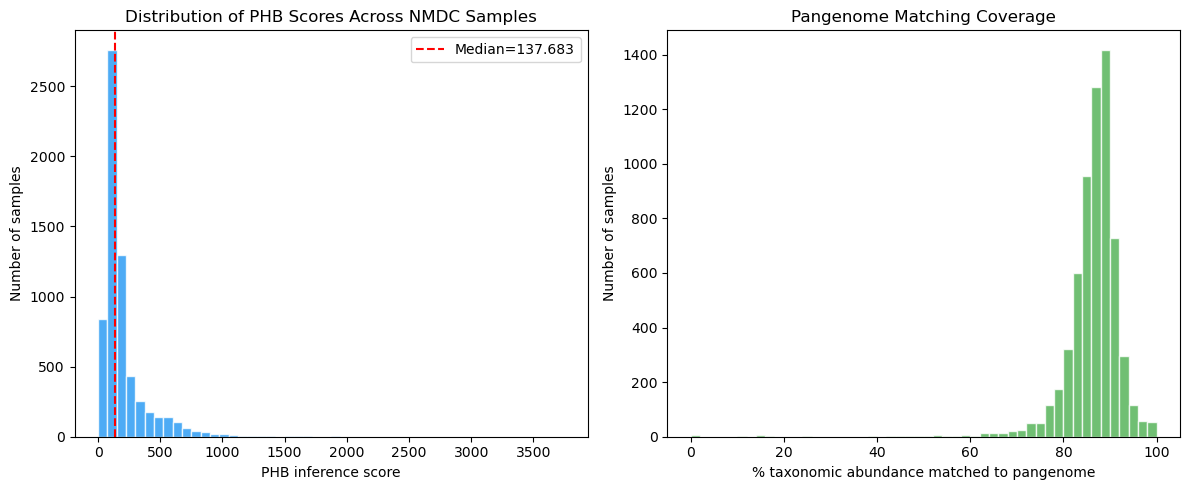

In [22]:
# Figure 1: PHB inference score distribution across samples
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = axes[0]
ax.hist(sample_phb['phb_score'], bins=50, color='#2196F3', alpha=0.8, edgecolor='white')
ax.set_xlabel('PHB inference score')
ax.set_ylabel('Number of samples')
ax.set_title('Distribution of PHB Scores Across NMDC Samples')
ax.axvline(sample_phb['phb_score'].median(), color='red', linestyle='--', 
           label=f'Median={sample_phb["phb_score"].median():.3f}')
ax.legend()

ax = axes[1]
ax.hist(sample_phb['pct_matched'], bins=50, color='#4CAF50', alpha=0.8, edgecolor='white')
ax.set_xlabel('% taxonomic abundance matched to pangenome')
ax.set_ylabel('Number of samples')
ax.set_title('Pangenome Matching Coverage')

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'nmdc_phb_by_environment.png'), dpi=150, bbox_inches='tight')
plt.show()

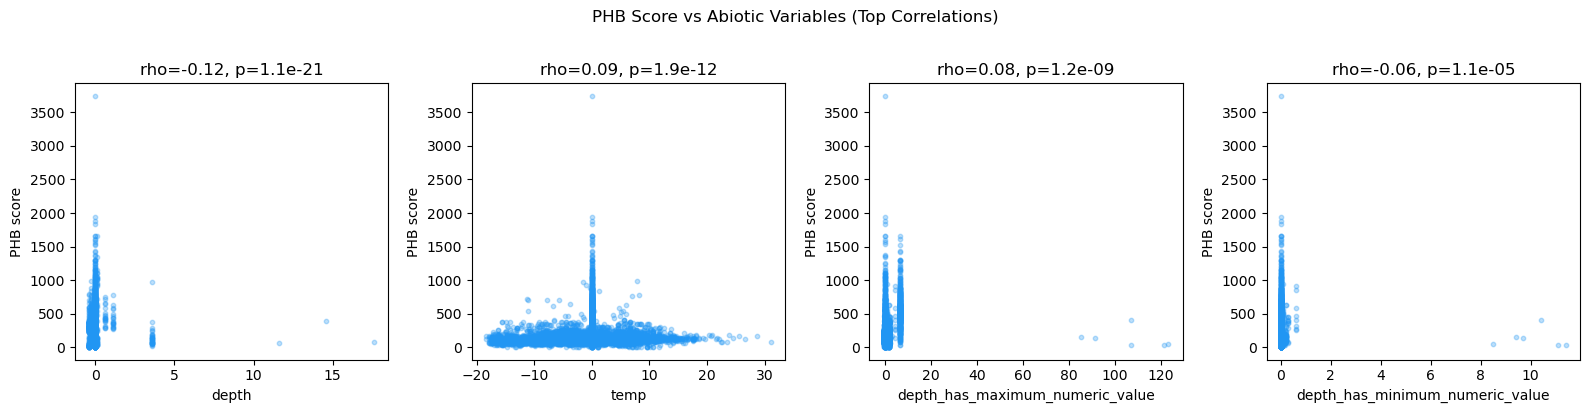

In [23]:
# Figure 2: PHB score vs key abiotic variables
# Plot top correlations (by p-value)
if len(corr_df) > 0:
    top_n = min(4, len(corr_df))
    top_corr = corr_df.head(top_n)
    
    fig, axes = plt.subplots(1, top_n, figsize=(4*top_n, 4))
    if top_n == 1:
        axes = [axes]
    
    for i, (_, row) in enumerate(top_corr.iterrows()):
        col = row['abiotic_variable']
        ax = axes[i]
        vals = pd.to_numeric(phb_abiotic[col], errors='coerce')
        valid = vals.notna() & phb_abiotic['phb_score'].notna()
        
        ax.scatter(vals[valid], phb_abiotic.loc[valid, 'phb_score'], 
                   alpha=0.3, s=10, color='#2196F3')
        # Clean column name for display
        clean_name = col.replace('annotations_', '').replace('_has_numeric_value', '')
        ax.set_xlabel(clean_name)
        ax.set_ylabel('PHB score')
        ax.set_title(f'rho={row["spearman_rho"]:.2f}, p={row["p_value"]:.1e}')
    
    plt.suptitle('PHB Score vs Abiotic Variables (Top Correlations)', y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, 'nmdc_phb_vs_abiotic.png'), dpi=150, bbox_inches='tight')
    plt.show()
else:
    print('No significant abiotic correlations found.')

In [24]:
# Save results
sample_phb.to_csv(os.path.join(DATA_DIR, 'nmdc_phb_prevalence.tsv'), sep='\t', index=False)

# Save correlation results
if len(corr_df) > 0:
    corr_df.to_csv(os.path.join(DATA_DIR, 'nmdc_abiotic_correlations.tsv'), sep='\t', index=False)

print(f'Saved PHB prevalence: {len(sample_phb):,} samples')
print(f'Saved abiotic correlations: {len(corr_df)} variables')

Saved PHB prevalence: 6,365 samples
Saved abiotic correlations: 21 variables


## Summary

### Key Findings (to be filled after execution)
- Per-sample functional annotations available?: ?
- Taxonomy-based PHB inference: ? samples scored
- Pangenome matching coverage: ?%
- Top abiotic correlations: ?
- PHB-related metabolites found: ?

### Caveats
- Taxonomy-based inference is indirect — assumes genus-level PHB prevalence applies to metagenome taxa
- Taxonomic classification methods (Centrifuge/Kraken/GOTTCHA) have different genus-level accuracy
- NMDC samples are biased toward specific ecosystems (soil, aquatic) per NMDC study portfolio
- Abiotic features are snapshots, not measures of temporal variability

### Next Notebook (NB05)
Subclade enrichment and cross-validation — test for differential PHB enrichment within clades and validate pangenome patterns against NMDC.